https://mp.weixin.qq.com/s/UJx0KJi15nCAXmYGyGEtIA

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
print(tf.__version__)

2.3.1


In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

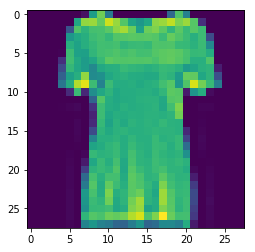

In [5]:
plt.imshow(x_train[10])

In [6]:
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train[...,tf.newaxis]
x_test = x_test[...,tf.newaxis]
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

x_train shape: (60000, 28, 28, 1) y_train shape: (60000,)


In [5]:
# 高级API搭建模型+高级API训练模型
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=(28,28,1)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dense(10,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 3,213,002
Trainable params: 3,213,002
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='../../dataset/model.weights.best.hdf5',verbose=1,save_best_only=True)
model.fit(x_train,y_train,batch_size=32,epochs=2,validation_data=(x_test,y_test),callbacks=[checkpointer])

Epoch 1/2
1875/1875 [==============================] - ETA: 0s - loss: 0.3637 - accuracy: 0.8697
Epoch 00001: val_loss improved from inf to 0.29203, saving model to ../../dataset\model.weights.best.hdf5
1875/1875 [==============================] - 49s 26ms/step - loss: 0.3637 - accuracy: 0.8697 - val_loss: 0.2920 - val_accuracy: 0.8920
Epoch 2/2
1875/1875 [==============================] - ETA: 0s - loss: 0.2336 - accuracy: 0.9153
Epoch 00002: val_loss improved from 0.29203 to 0.28417, saving model to ../../dataset\model.weights.best.hdf5
1875/1875 [==============================] - 50s 26ms/step - loss: 0.2336 - accuracy: 0.9153 - val_loss: 0.2842 - val_accuracy: 0.8972


In [7]:
# 低级API搭建模型+高级API训练模型
class FashionNet(tf.keras.Model):
    def __init__(self):
        super(FashionNet,self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32,3,activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(128,activation='relu')
        self.d2 = tf.keras.layers.Dense(10,activation='softmax')
    def call(self,x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        out = self.d2(x)
        return out

In [8]:
model = FashionNet()
model.build(input_shape=(None,28,28,1))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='../../dataset/model.weights.best.hdf5',verbose=1,save_best_only=True)
model.fit(x_train,y_train,batch_size=32,epochs=2,validation_data=(x_test,y_test),callbacks=[checkpointer])keras

Epoch 1/2
1873/1875 [============================>.] - ETA: 0s - loss: 0.3786 - accuracy: 0.8640
Epoch 00001: val_loss improved from inf to 0.31390, saving model to ../../dataset\model.weights.best.hdf5
1875/1875 [==============================] - 44s 23ms/step - loss: 0.3786 - accuracy: 0.8640 - val_loss: 0.3139 - val_accuracy: 0.8863
Epoch 2/2
1874/1875 [============================>.] - ETA: 0s - loss: 0.2498 - accuracy: 0.9078
Epoch 00002: val_loss improved from 0.31390 to 0.27592, saving model to ../../dataset\model.weights.best.hdf5
1875/1875 [==============================] - 42s 22ms/step - loss: 0.2497 - accuracy: 0.9078 - val_loss: 0.2759 - val_accuracy: 0.9004


In [3]:
# 低级API搭建模型+低级API训练模型
class FashionNet(tf.keras.Model):
    def __init__(self):
        super(FashionNet,self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32,3,activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(128,activation='relu')
        self.d2 = tf.keras.layers.Dense(10,activation='softmax')
    def call(self,x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        out = self.d2(x)
        return out

In [9]:
model = FashionNet()
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_ds = train_ds.batch(batch_size=32)
test_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = test_ds.batch(batch_size=32)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
def train_step(images,labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels,predictions)
        gradients = tape.gradient(loss,model.trainable_variables)
        optimizer.apply_gradients(zip(gradients,model.trainable_variables))
        train_loss(loss)
        train_accuracy(labels,predictions)
def test_step(images,labels):
    predictions = model(images)
    t_loss = loss_object(labels,predictions)
    test_loss(t_loss)
    test_accuracy(labels,predictions)
EPOCHS = 5
for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    for images,labels in train_ds:
        train_step(images,labels)
    for test_images,test_labels in test_ds:
        test_step(test_images,test_labels)
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch+1,train_loss.result(),train_accuracy.result()*100,test_loss.result(),test_accuracy.result()*100))

W1102 15:10:32.501978  4812 base_layer.py:2377] Layer fashion_net_2 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Epoch 1, Loss: 0.3820117115974426, Accuracy: 86.22666931152344, Test Loss: 0.28103160858154297, Test Accuracy: 89.39666748046875
Epoch 2, Loss: 0.2455371767282486, Accuracy: 90.97166442871094, Test Loss: 0.20824266970157623, Test Accuracy: 92.21666717529297
Epoch 3, Loss: 0.18938180804252625, Accuracy: 93.13333892822266, Test Loss: 0.1741063892841339, Test Accuracy: 93.63500213623047
Epoch 4, Loss: 0.14432667195796967, Accuracy: 94.85832977294922, Test Loss: 0.13567322492599487, Test Accuracy: 94.99666595458984
Epoch 5, Loss: 0.1090964525938034, Accuracy: 96.14666748046875, Test Loss: 0.10261349380016327, Test Accuracy: 96.14166259765625


In [12]:
# 高级API搭建模型+低级API训练模型
inputs = tf.keras.layers.Input(shape=(28,28,1))
conv2d = tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu')(inputs)
flat = tf.keras.layers.Flatten()(conv2d)
dense = tf.keras.layers.Dense(128,activation='relu')(flat)
outputs = tf.keras.layers.Dense(10,activation='softmax')(dense)
model = tf.keras.models.Model(inputs=inputs,outputs=outputs)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               3211392   
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1290      
Total params: 3,213,002
Trainable params: 3,213,002
Non-trainable params: 0
_________________________________________________________________


In [13]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_ds = train_ds.batch(batch_size=32)
test_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = test_ds.batch(batch_size=32)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
def train_step(images,labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels,predictions)
        gradients = tape.gradient(loss,model.trainable_variables)
        optimizer.apply_gradients(zip(gradients,model.trainable_variables))
        train_loss(loss)
        train_accuracy(labels,predictions)
def test_step(images,labels):
    predictions = model(images)
    t_loss = loss_object(labels,predictions)
    test_loss(t_loss)
    test_accuracy(labels,predictions)
EPOCHS = 5
for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    for images,labels in train_ds:
        train_step(images,labels)
    for test_images,test_labels in test_ds:
        test_step(test_images,test_labels)
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch+1,train_loss.result(),train_accuracy.result()*100,test_loss.result(),test_accuracy.result()*100))

Epoch 1, Loss: 0.37241584062576294, Accuracy: 86.58333587646484, Test Loss: 0.259939044713974, Test Accuracy: 90.27333068847656
Epoch 2, Loss: 0.24234150350093842, Accuracy: 91.02999877929688, Test Loss: 0.19628146290779114, Test Accuracy: 92.68000030517578
Epoch 3, Loss: 0.1828906387090683, Accuracy: 93.36166381835938, Test Loss: 0.15902476012706757, Test Accuracy: 94.05333709716797
Epoch 4, Loss: 0.13792045414447784, Accuracy: 95.02166748046875, Test Loss: 0.1326255202293396, Test Accuracy: 94.97333526611328
Epoch 5, Loss: 0.10284900665283203, Accuracy: 96.28499603271484, Test Loss: 0.12878020107746124, Test Accuracy: 95.33666229248047
